# Three-Model DPF Comparison: Learning dt via OT Resampling

## Models (all share OT resampling + learnable dt)

| | Model A | Model B | Model C |
|---|---|---|---|
| **Proposal** | Bootstrap (prior) | Learned Gφ | Learned Gφ |
| **Measurement** | Analytic Student-t | Analytic Student-t | Learned Fθ |
| **Learns** | dt | dt (Gφ pre-trained) | dt (Gφ+Fθ pre-trained) |


## 1. Setup

In [1]:
!pip install -q tensorflow-probability

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import time

tfd = tfp.distributions
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
print(f"TF: {tf.__version__}, TFP: {tfp.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TF: 2.19.0, TFP: 0.25.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Utilities + Sinkhorn OT Resampler

In [2]:
def normalize_log_weights(log_w):
    log_sum = tf.math.reduce_logsumexp(log_w, axis=-1, keepdims=True)
    return log_w - log_sum, tf.squeeze(log_sum, axis=-1)

def effective_sample_size(log_w_norm):
    return tf.exp(-tf.math.reduce_logsumexp(2.0 * log_w_norm, axis=-1))

def weighted_mean(particles, log_w):
    w = tf.exp(log_w)
    return tf.reduce_sum(w[:, :, None] * particles, axis=1)


class SinkhornResampler:
    def __init__(self, epsilon=0.5, num_iters=20):
        self.epsilon = epsilon
        self.num_iters = num_iters

    def __call__(self, particles, log_w_norm):
        N = tf.shape(particles)[1]
        Nf = tf.cast(N, tf.float32)

        diff = particles[:, :, None, :] - particles[:, None, :, :]
        C = tf.reduce_sum(diff ** 2, axis=-1)

        log_a = log_w_norm
        log_b = -tf.math.log(Nf) * tf.ones_like(log_a)
        log_K = -C / self.epsilon

        log_u = tf.zeros_like(log_a)
        log_v = tf.zeros_like(log_b)

        for _ in range(self.num_iters):
            log_u = log_a - tf.math.reduce_logsumexp(log_K + log_v[:, None, :], axis=-1)
            log_v = log_b - tf.math.reduce_logsumexp(log_K + log_u[:, :, None], axis=1)

        T = tf.exp(log_u[:, :, None] + log_K + log_v[:, None, :])
        transform = Nf * tf.transpose(T, perm=[0, 2, 1])
        resampled = tf.matmul(transform, particles)
        new_log_w = -tf.math.log(Nf) * tf.ones([tf.shape(particles)[0], N], dtype=tf.float32)
        return resampled, new_log_w

print("Utilities + SinkhornResampler ready.")

Utilities + SinkhornResampler ready.


## 3. Range-Bearing SSM (learnable dt)

In [3]:
class RangeBearingSSM:
    def __init__(self, dt_init=0.01, q_std=0.1, s_r=0.01, s_th=0.01, nu=2.0):
        self.log_dt = tf.Variable(
            tf.math.log(tf.constant(dt_init, dtype=tf.float32)), name='log_dt')
        self.q_std = q_std
        self.s_r = s_r
        self.s_th = s_th
        self.nu = nu

    @property
    def dt(self):
        return tf.exp(self.log_dt)

    def _build_F_and_Q(self):
        dt = self.dt
        q = self.q_std ** 2
        F = tf.stack([
            tf.stack([1., 0., dt, 0.]),
            tf.stack([0., 1., 0., dt]),
            tf.stack([0., 0., 1., 0.]),
            tf.stack([0., 0., 0., 1.]),
        ])
        dt2, dt3 = dt * dt, dt * dt * dt
        Q = tf.stack([
            tf.stack([dt3/3*q, 0., dt2/2*q, 0.]),
            tf.stack([0., dt3/3*q, 0., dt2/2*q]),
            tf.stack([dt2/2*q, 0., dt*q, 0.]),
            tf.stack([0., dt2/2*q, 0., dt*q]),
        ])
        return F, Q

    def h(self, x):
        px, py = x[..., 0], x[..., 1]
        return tf.stack([tf.sqrt(px**2 + py**2 + 1e-8), tf.atan2(py, px)], axis=-1)

    def transition_sample(self, particles):
        F, Q = self._build_F_and_Q()
        Q_chol = tf.linalg.cholesky(Q + 1e-6 * tf.eye(4))
        mean = tf.linalg.matvec(F[None, None], particles)
        noise = tfd.MultivariateNormalTriL(loc=tf.zeros(4), scale_tril=Q_chol).sample(tf.shape(particles)[:2])
        return mean + noise

    def transition_log_prob(self, x_t, x_tm1):
        F, Q = self._build_F_and_Q()
        Q_chol = tf.linalg.cholesky(Q + 1e-6 * tf.eye(4))
        mean = tf.linalg.matvec(F[None, None], x_tm1)
        return tfd.MultivariateNormalTriL(loc=mean, scale_tril=Q_chol).log_prob(x_t)

    def observation_log_prob(self, y_t, particles):
        pred = self.h(particles)
        if y_t.shape.ndims == 1:
            y_t = y_t[None, None, :]
        diff = pred - y_t
        diff_r = diff[..., 0]
        diff_th = tf.atan2(tf.sin(diff[..., 1]), tf.cos(diff[..., 1]))
        log_p_r = tfd.StudentT(df=self.nu, loc=0., scale=self.s_r).log_prob(diff_r)
        log_p_th = tfd.StudentT(df=self.nu, loc=0., scale=self.s_th).log_prob(diff_th)
        return log_p_r + log_p_th

    def generate_data(self, T=100, dt_true=0.01, x0=None):
        if x0 is None:
            x0 = np.array([1.0, 0.5, 0.1, 0.05])
        dt = dt_true
        q = self.q_std ** 2
        F_np = np.array([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])
        Q_np = np.array([
            [dt**3/3*q,0,dt**2/2*q,0],[0,dt**3/3*q,0,dt**2/2*q],
            [dt**2/2*q,0,dt*q,0],[0,dt**2/2*q,0,dt*q]])
        Q_chol = np.linalg.cholesky(Q_np + 1e-8*np.eye(4))
        xs, ys = np.zeros((T,4)), np.zeros((T,2))
        x = x0.copy()
        for t in range(T):
            x = F_np @ x + Q_chol @ np.random.randn(4)
            xs[t] = x
            r = np.sqrt(x[0]**2 + x[1]**2)
            th = np.arctan2(x[1], x[0])
            ys[t] = [r + np.random.standard_t(self.nu)*self.s_r,
                      th + np.random.standard_t(self.nu)*self.s_th]
        return xs, ys

# Generate data
DT_TRUE = 0.01
T_STEPS = 100
ssm_data = RangeBearingSSM(dt_init=DT_TRUE)
xs_true, ys_obs = ssm_data.generate_data(T=T_STEPS, dt_true=DT_TRUE)
observations = tf.constant(ys_obs, dtype=tf.float32)
print(f"Data: T={T_STEPS}, true dt={DT_TRUE}")

Data: T=100, true dt=0.01


## 4. Conditional RealNVP

In [4]:
class ConditionedCouplingLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, context_dim, hidden_dim=16, split_dim=None, **kwargs):
        super().__init__(**kwargs)
        self.split_dim = split_dim or input_dim // 2
        d_b = input_dim - self.split_dim
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim, activation='relu'),
            tf.keras.layers.Dense(2 * d_b, kernel_initializer='zeros', bias_initializer='zeros'),
        ])

    def call(self, x, context, inverse=False):
        x_a, x_b = x[..., :self.split_dim], x[..., self.split_dim:]
        st = self.net(tf.concat([x_a, context], axis=-1))
        d_b = tf.shape(x_b)[-1]
        s = tf.tanh(st[..., :d_b]) * 0.5
        t = st[..., d_b:]
        if not inverse:
            return tf.concat([x_a, x_b * tf.exp(s) + t], axis=-1), tf.reduce_sum(s, axis=-1)
        else:
            return tf.concat([x_a, (x_b - t) * tf.exp(-s)], axis=-1), -tf.reduce_sum(s, axis=-1)


class ConditionalRealNVP(tf.keras.Model):
    def __init__(self, input_dim, context_dim, n_layers=3, hidden_dim=16, **kwargs):
        super().__init__(**kwargs)
        self._flow_layers = []
        for i in range(n_layers):
            split = input_dim // 2 if i % 2 == 0 else input_dim - input_dim // 2
            self._flow_layers.append(ConditionedCouplingLayer(
                input_dim=input_dim, context_dim=context_dim,
                hidden_dim=hidden_dim, split_dim=split))

    def call(self, x, context, inverse=False):
        total_log_det = tf.zeros(tf.shape(x)[:-1])
        for layer in (list(reversed(self._flow_layers)) if inverse else self._flow_layers):
            x, ld = layer(x, context, inverse=inverse)
            total_log_det += ld
        return x, total_log_det

print("ConditionalRealNVP ready.")

ConditionalRealNVP ready.


## 5. Three Models

All share the same filter loop structure. The differences are only in proposal and measurement.

In [5]:
class DPFBase:
    """Base filter loop shared by all three models."""

    def __init__(self, ssm, resampler, ess_threshold=0.5):
        self.ssm = ssm
        self.resampler = resampler
        self.ess_threshold = ess_threshold

    @property
    def dt(self):
        return self.ssm.dt

    def propose(self, particles, y_t, batch_size, n_particles):
        """Override in subclass. Returns (proposed_particles, log_w_correction)."""
        raise NotImplementedError

    def measure(self, y_t, particles):
        """Override in subclass. Returns log p(y|x)."""
        raise NotImplementedError

    def filter(self, observations, batch_size=1, n_particles=100):
        T_len = observations.shape[0]
        Nf = tf.cast(n_particles, tf.float32)

        particles = (tf.random.normal([batch_size, n_particles, 4]) * 0.5
                     + tf.constant([1.0, 0.5, 0.1, 0.05])[None, None, :])
        log_w = -tf.math.log(Nf) * tf.ones([batch_size, n_particles])

        all_particles, all_log_w, all_ess = [], [], []
        total_log_evidence = tf.zeros([batch_size])

        for t in range(T_len):
            y_t = observations[t]
            ess = effective_sample_size(log_w)
            all_ess.append(tf.reduce_mean(ess).numpy())

            if tf.reduce_any(ess < self.ess_threshold * Nf):
                particles, log_w = self.resampler(particles, log_w)

            x_prev = particles
            proposed, log_w_correction = self.propose(
                particles, y_t, batch_size, n_particles)
            log_lik = self.measure(y_t, proposed)

            log_w_unnorm = log_w + log_lik + log_w_correction
            log_w, log_ev_t = normalize_log_weights(log_w_unnorm)
            total_log_evidence += log_ev_t

            particles = proposed
            all_particles.append(particles)
            all_log_w.append(log_w)

        return all_particles, all_log_w, total_log_evidence, all_ess


class ModelA(DPFBase):
    """Bootstrap proposal + analytic measurement."""

    def __init__(self, dt_init, **kwargs):
        ssm = RangeBearingSSM(dt_init=dt_init)
        super().__init__(ssm, SinkhornResampler(), **kwargs)

    @property
    def trainable_variables(self):
        return [self.ssm.log_dt]

    def propose(self, particles, y_t, batch_size, n_particles):
        return self.ssm.transition_sample(particles), 0.0  # no correction

    def measure(self, y_t, particles):
        return self.ssm.observation_log_prob(y_t, particles)


class ModelB(DPFBase):
    """Learned proposal Gφ + analytic measurement."""

    def __init__(self, dt_init, G_phi=None, **kwargs):
        ssm = RangeBearingSSM(dt_init=dt_init)
        super().__init__(ssm, SinkhornResampler(), **kwargs)
        self.G_phi = G_phi or ConditionalRealNVP(
            input_dim=4, context_dim=2, n_layers=3, hidden_dim=16, name='G_phi')

    @property
    def trainable_variables(self):
        return [self.ssm.log_dt]

    def propose(self, particles, y_t, batch_size, n_particles):
        x_prev = particles
        x_bootstrap = self.ssm.transition_sample(particles)
        ctx = tf.broadcast_to(y_t[None, None, :], [batch_size, n_particles, 2])
        x_proposed, log_det_G = self.G_phi(x_bootstrap, ctx)

        # IS correction: log p(x_proposed|x_prev) - log q(x_proposed)
        # log q = log p_trans(x_bootstrap|x_prev) - log_det_G
        log_p_proposed = self.ssm.transition_log_prob(x_proposed, x_prev)
        log_p_bootstrap = self.ssm.transition_log_prob(x_bootstrap, x_prev)
        correction = log_p_proposed - log_p_bootstrap + log_det_G
        return x_proposed, correction

    def measure(self, y_t, particles):
        return self.ssm.observation_log_prob(y_t, particles)


class ModelC(DPFBase):
    """Learned proposal Gφ + learned measurement Fθ."""

    def __init__(self, dt_init, G_phi=None, F_theta=None, **kwargs):
        ssm = RangeBearingSSM(dt_init=dt_init)
        super().__init__(ssm, SinkhornResampler(), **kwargs)
        self.G_phi = G_phi or ConditionalRealNVP(
            input_dim=4, context_dim=2, n_layers=3, hidden_dim=16, name='G_phi')
        self.F_theta = F_theta or ConditionalRealNVP(
            input_dim=2, context_dim=4, n_layers=2, hidden_dim=16, name='F_theta')

    @property
    def trainable_variables(self):
        return [self.ssm.log_dt]

    @property
    def flow_variables(self):
        return self.G_phi.trainable_variables + self.F_theta.trainable_variables

    def propose(self, particles, y_t, batch_size, n_particles):
        x_prev = particles
        x_bootstrap = self.ssm.transition_sample(particles)
        ctx = tf.broadcast_to(y_t[None, None, :], [batch_size, n_particles, 2])
        x_proposed, log_det_G = self.G_phi(x_bootstrap, ctx)

        log_p_proposed = self.ssm.transition_log_prob(x_proposed, x_prev)
        log_p_bootstrap = self.ssm.transition_log_prob(x_bootstrap, x_prev)
        correction = log_p_proposed - log_p_bootstrap + log_det_G
        return x_proposed, correction

    def measure(self, y_t, particles):
        B, N = tf.shape(particles)[0], tf.shape(particles)[1]  # noqa: F841
        y_tiled = tf.broadcast_to(y_t[None, None, :], [tf.shape(particles)[0], tf.shape(particles)[1], 2])
        z, log_det = self.F_theta(y_tiled, particles)
        log_pz = tf.reduce_sum(tfd.Normal(0., 1.).log_prob(z), axis=-1)
        return log_pz + log_det


print("Models A, B, C defined.")

Models A, B, C defined.


## 6. Pre-train Flows for Models B and C

Train Gφ (shared by B and C) and Fθ (C only) on multi-dt trajectories.
Model B and C share the same Gφ weights.

In [6]:
# Pre-generate multi-dt trajectories
DT_VALUES = [0.005, 0.01, 0.015, 0.02, 0.025]
TRAJS_PER_DT = 4
all_train_trajs, all_train_dt = [], []

print(f"Generating trajectories for dt in {DT_VALUES}...")
for dt_val in DT_VALUES:
    for j in range(TRAJS_PER_DT):
        np.random.seed(int(dt_val * 1e5) + j * 31)
        ssm_gen = RangeBearingSSM(dt_init=dt_val)
        _, ys_i = ssm_gen.generate_data(T=T_STEPS, dt_true=dt_val)
        all_train_trajs.append(tf.constant(ys_i, dtype=tf.float32))
        all_train_dt.append(dt_val)

N_TRAJS = len(all_train_trajs)
print(f"Total: {N_TRAJS} trajectories")

Generating trajectories for dt in [0.005, 0.01, 0.015, 0.02, 0.025]...
Total: 20 trajectories


Flow parameters: 2064

Pre-training Gφ + Fθ for 200 steps...
 Step        Loss   dt_used
------------------------------
   25      130.27    0.0050
   50      127.93    0.0150
   75      125.63    0.0200
  100      117.97    0.0050
  125      114.94    0.0150
  150      109.64    0.0050
  175      100.26    0.0150
  200       95.51    0.0050

Pre-training complete. Saved Gφ (18 arrays) + Fθ (12 arrays)


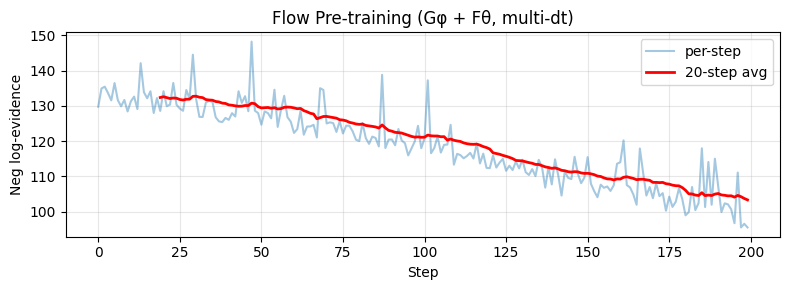

In [7]:
# --- Pre-train Model C (which has both Gφ and Fθ) ---
# We'll extract Gφ weights for Model B afterwards.

model_c_pretrain = ModelC(dt_init=DT_TRUE)
# Warm-up
_ = model_c_pretrain.filter(observations[:3], batch_size=1, n_particles=10)

flow_vars = model_c_pretrain.flow_variables
print(f"Flow parameters: {sum(v.numpy().size for v in flow_vars)}")

optimizer_pre = tf.keras.optimizers.Adam(learning_rate=3e-4)
EMA_DECAY = 0.9
ema_weights = [tf.identity(v) for v in flow_vars]

N_PRETRAIN = 200
PT_PARTICLES = 100
PT_BATCH = 4
PT_SEQ = 50

pretrain_losses = []
print(f"\nPre-training Gφ + Fθ for {N_PRETRAIN} steps...")
print(f"{'Step':>5}  {'Loss':>10}  {'dt_used':>8}")
print("-" * 30)

for step in range(N_PRETRAIN):
    tf.random.set_seed(step * 137)
    traj_idx = np.random.randint(0, N_TRAJS)
    obs_traj = all_train_trajs[traj_idx]
    dt_used = all_train_dt[traj_idx]
    model_c_pretrain.ssm.log_dt.assign(tf.math.log(tf.constant(dt_used, dtype=tf.float32)))

    t0 = np.random.randint(0, T_STEPS - PT_SEQ)
    obs_sub = obs_traj[t0:t0 + PT_SEQ]

    with tf.GradientTape() as tape:
        _, _, log_ev, _ = model_c_pretrain.filter(
            obs_sub, batch_size=PT_BATCH, n_particles=PT_PARTICLES)
        loss = -tf.reduce_mean(log_ev)

    grads = tape.gradient(loss, flow_vars)
    grads = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in grads]
    valid = [(g, v) for g, v in zip(grads, flow_vars) if g is not None]
    if valid:
        optimizer_pre.apply_gradients(valid)

    for i, v in enumerate(flow_vars):
        ema_weights[i] = EMA_DECAY * ema_weights[i] + (1.0 - EMA_DECAY) * v

    pretrain_losses.append(loss.numpy())
    if (step + 1) % 25 == 0:
        print(f"{step+1:5d}  {loss.numpy():10.2f}  {dt_used:8.4f}")

# Apply EMA
for i, v in enumerate(flow_vars):
    v.assign(ema_weights[i])
model_c_pretrain.ssm.log_dt.assign(tf.math.log(tf.constant(DT_TRUE, dtype=tf.float32)))

# Save weights
G_PHI_WEIGHTS = model_c_pretrain.G_phi.get_weights()
F_THETA_WEIGHTS = model_c_pretrain.F_theta.get_weights()
print(f"\nPre-training complete. Saved Gφ ({len(G_PHI_WEIGHTS)} arrays) + Fθ ({len(F_THETA_WEIGHTS)} arrays)")

plt.figure(figsize=(8, 3))
plt.plot(pretrain_losses, alpha=0.4, label='per-step')
w = 20
if len(pretrain_losses) >= w:
    sm = np.convolve(pretrain_losses, np.ones(w)/w, mode='valid')
    plt.plot(np.arange(w-1, len(pretrain_losses)), sm, 'r-', lw=2, label=f'{w}-step avg')
plt.xlabel('Step'); plt.ylabel('Neg log-evidence')
plt.title('Flow Pre-training (Gφ + Fθ, multi-dt)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

In [15]:
from google.colab import drive
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/MyDrive/dpf_pretrained'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
# Save
model_c_pretrain.G_phi.save_weights(os.path.join(SAVE_DIR, 'G_phi.weights.h5'))
model_c_pretrain.F_theta.save_weights(os.path.join(SAVE_DIR, 'F_theta.weights.h5'))
print(f"Saved to {SAVE_DIR}")

# To load later (after rebuilding the model):
# model_b_pretrain = ModelB_CNF_OT(dt_init=DT_TRUE, ...)
# _ = model_b_pretrain.filter(observations[:5], batch_size=1, n_particles=20)  # build
# model_b_pretrain.G_phi.load_weights(os.path.join(SAVE_DIR, 'G_phi.weights.h5'))
# model_b_pretrain.F_theta.load_weights(os.path.join(SAVE_DIR, 'F_theta.weights.h5'))

Saved to /content/drive/MyDrive/dpf_pretrained


## 7. Learn dt — Three-Way Comparison

All start at dt=0.02 (2× true). 100 gradient steps, 2 seeds.
~30 min total expected runtime.

In [12]:
DT_INIT = 0.02
N_STEPS = 300
LR = 2e-3
N_P = 50   # particles (keep low for speed)
B = 4      # batch
SEQ = 50   # subsequence length
N_SEEDS = 2

def learn_dt(name, build_fn, n_seeds=N_SEEDS):
    results = {'dt': [], 'loss': [], 'grad': [], 'rmse': [], 'ess': [], 'time': []}

    for seed in range(n_seeds):
        print(f"  {name} seed {seed+1}/{n_seeds}...", end=" ", flush=True)
        tf.random.set_seed(seed * 999)
        np.random.seed(seed * 999)

        model = build_fn()
        opt = tf.keras.optimizers.Adam(learning_rate=LR)
        dt_tr, loss_tr, grad_tr = [model.dt.numpy()], [], []

        t0 = time.time()
        for step in range(N_STEPS):
            ts = np.random.randint(0, T_STEPS - SEQ)
            with tf.GradientTape() as tape:
                _, _, log_ev, _ = model.filter(
                    observations[ts:ts+SEQ], batch_size=B, n_particles=N_P)
                loss = -tf.reduce_mean(log_ev)

            g = tape.gradient(loss, [model.ssm.log_dt])[0]
            gm = tf.abs(g).numpy() if g is not None else 0.0
            if g is not None:
                opt.apply_gradients([(tf.clip_by_norm(g[None], 1.0)[0], model.ssm.log_dt)])

            dt_tr.append(model.dt.numpy())
            loss_tr.append(loss.numpy())
            grad_tr.append(gm)

        elapsed = time.time() - t0

        # Final eval
        all_p, all_lw, _, ess_tr = model.filter(observations, batch_size=1, n_particles=200)
        errs = [np.sum((weighted_mean(all_p[t], all_lw[t]).numpy()[0, :2] - xs_true[t, :2])**2)
                for t in range(len(all_p))]
        rmse = np.sqrt(np.mean(errs))

        results['dt'].append(dt_tr)
        results['loss'].append(loss_tr)
        results['grad'].append(grad_tr)
        results['rmse'].append(rmse)
        results['ess'].append(np.mean(ess_tr))
        results['time'].append(elapsed)

        print(f"dt: {DT_INIT:.4f}->{dt_tr[-1]:.4f} (true={DT_TRUE}), RMSE={rmse:.4f}, {elapsed:.0f}s")

    return results


# === Model A ===
print("=== Model A: Bootstrap + Analytic ===")
results_a = learn_dt("A", lambda: ModelA(dt_init=DT_INIT))

# === Model B ===
print("\n=== Model B: Learned Gφ + Analytic ===")
def build_b():
    m = ModelB(dt_init=DT_INIT)
    _ = m.filter(observations[:3], batch_size=1, n_particles=10)
    m.G_phi.set_weights(G_PHI_WEIGHTS)
    return m
results_b = learn_dt("B", build_b)

# === Model C ===
print("\n=== Model C: Learned Gφ + Learned Fθ ===")
def build_c():
    m = ModelC(dt_init=DT_INIT)
    _ = m.filter(observations[:3], batch_size=1, n_particles=10)
    m.G_phi.set_weights(G_PHI_WEIGHTS)
    m.F_theta.set_weights(F_THETA_WEIGHTS)
    return m
results_c = learn_dt("C", build_c)

print("\nDone.")

=== Model A: Bootstrap + Analytic ===
  A seed 1/2... dt: 0.0200->0.0124 (true=0.01), RMSE=0.3204, 1534s
  A seed 2/2... dt: 0.0200->0.0123 (true=0.01), RMSE=0.1786, 1547s

=== Model B: Learned Gφ + Analytic ===
  B seed 1/2... dt: 0.0200->0.0127 (true=0.01), RMSE=0.0175, 3718s
  B seed 2/2... dt: 0.0200->0.0125 (true=0.01), RMSE=0.1187, 3786s

=== Model C: Learned Gφ + Learned Fθ ===
  C seed 1/2... dt: 0.0200->0.0364 (true=0.01), RMSE=2.0673, 3547s
  C seed 2/2... dt: 0.0200->0.0364 (true=0.01), RMSE=1.7728, 3456s

Done.


## 8. Results

In [13]:
# Summary table
print(f"{'':20s} {'Model A':>12s} {'Model B':>12s} {'Model C':>12s}")
print(f"{'':20s} {'(Bootstrap)':>12s} {'(Gφ+Analyt)':>12s} {'(Gφ+Fθ)':>12s}")
print("-" * 60)

for label, key, fmt in [
    ('Final dt (mean)', 'dt', '.4f'),
    ('|dt_err|', 'dt', '.4f'),
    ('RMSE (mean)', 'rmse', '.4f'),
    ('ESS (mean)', 'ess', '.1f'),
    ('Time/run (s)', 'time', '.0f'),
]:
    vals = []
    for r in [results_a, results_b, results_c]:
        if label == 'Final dt (mean)':
            v = np.mean([tr[-1] for tr in r['dt']])
        elif label == '|dt_err|':
            v = np.mean([abs(tr[-1] - DT_TRUE) for tr in r['dt']])
        elif key == 'rmse':
            v = np.mean(r[key])
        elif key == 'ess':
            v = np.mean(r[key])
        else:
            v = np.mean(r[key])
        vals.append(v)
    print(f"{label:20s} {vals[0]:12{fmt}} {vals[1]:12{fmt}} {vals[2]:12{fmt}}")

print(f"\nTrue dt = {DT_TRUE}, Init dt = {DT_INIT}")

                          Model A      Model B      Model C
                      (Bootstrap)  (Gφ+Analyt)      (Gφ+Fθ)
------------------------------------------------------------
Final dt (mean)            0.0124       0.0126       0.0364
|dt_err|                   0.0024       0.0026       0.0264
RMSE (mean)                0.2495       0.0681       1.9200
ESS (mean)                  157.8        152.7        146.7
Time/run (s)                 1540         3752         3502

True dt = 0.01, Init dt = 0.02


## 9. Plots

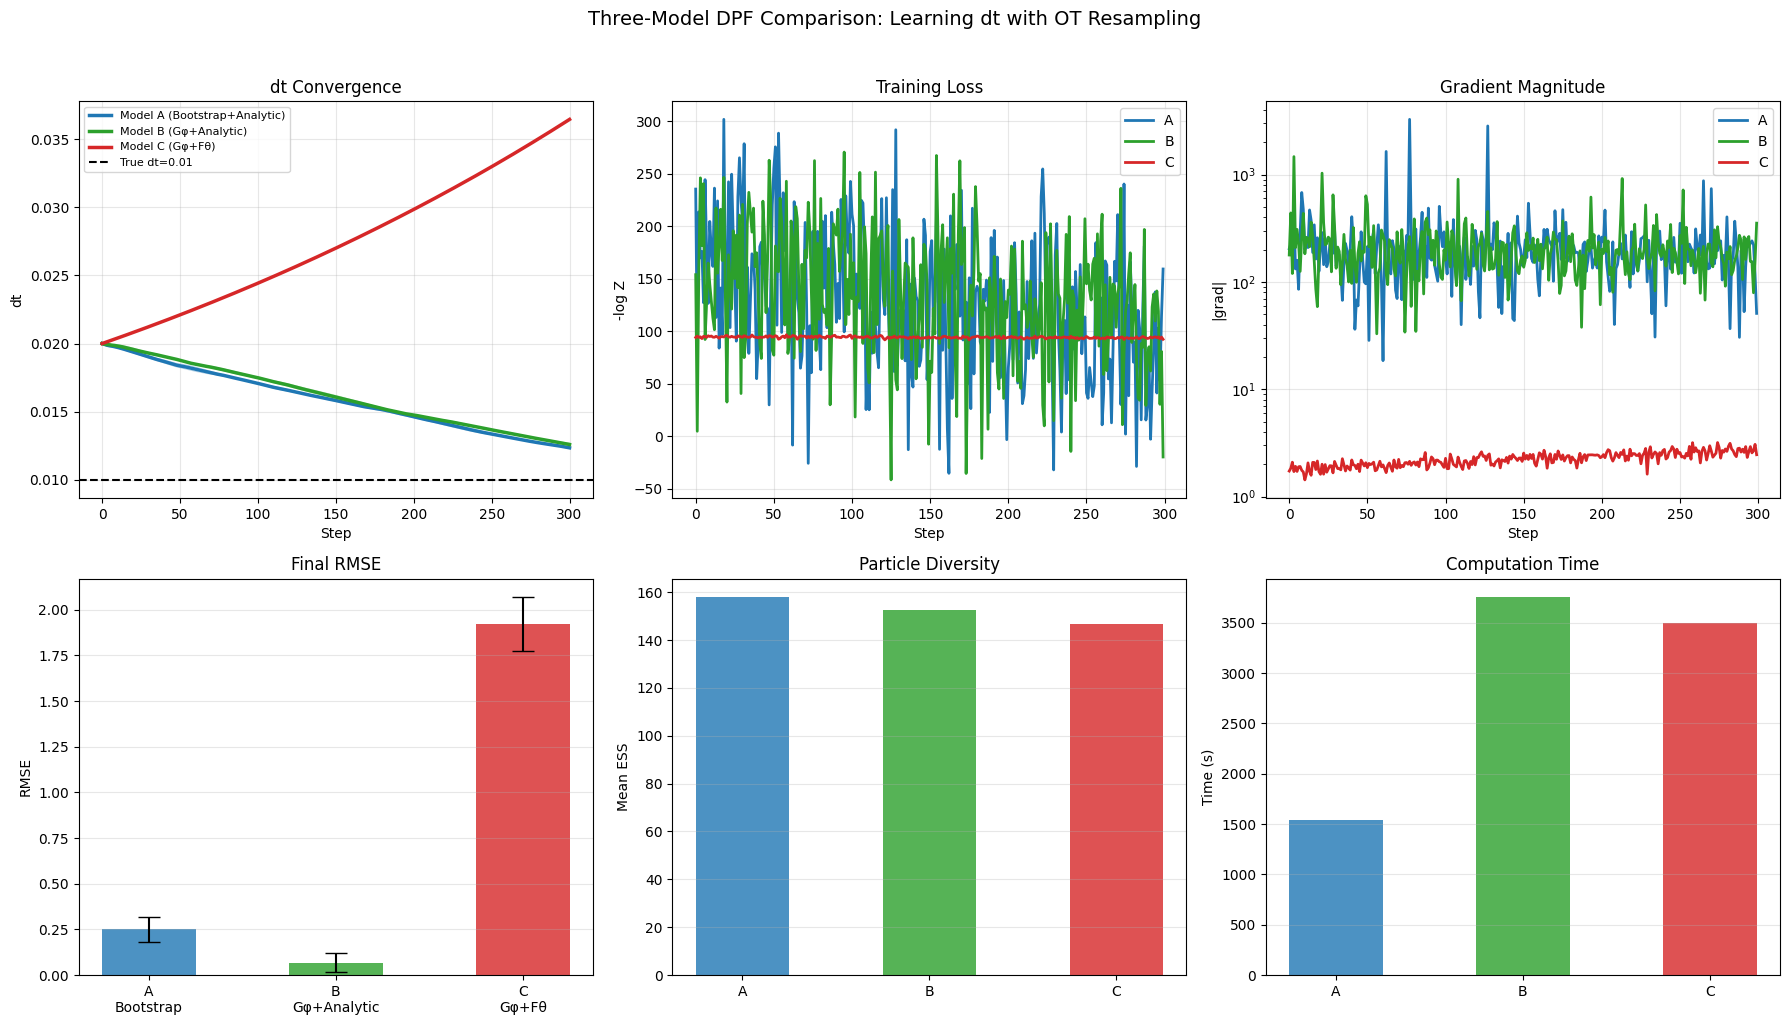

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
colors = {'A': 'C0', 'B': 'C2', 'C': 'C3'}
labels = {'A': 'Model A (Bootstrap+Analytic)',
          'B': 'Model B (Gφ+Analytic)',
          'C': 'Model C (Gφ+Fθ)'}

# --- dt convergence ---
ax = axes[0, 0]
for name, res, c in [('A', results_a, 'C0'), ('B', results_b, 'C2'), ('C', results_c, 'C3')]:
    for tr in res['dt']:
        ax.plot(tr, color=c, alpha=0.3, lw=0.8)
    ax.plot(np.mean(res['dt'], axis=0), color=c, lw=2.5, label=labels[name])
ax.axhline(DT_TRUE, color='k', ls='--', lw=1.5, label=f'True dt={DT_TRUE}')
ax.set_xlabel('Step'); ax.set_ylabel('dt'); ax.set_title('dt Convergence')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# --- Loss ---
ax = axes[0, 1]
for name, res, c in [('A', results_a, 'C0'), ('B', results_b, 'C2'), ('C', results_c, 'C3')]:
    ax.plot(np.mean(res['loss'], axis=0), color=c, lw=2, label=name)
ax.set_xlabel('Step'); ax.set_ylabel('-log Z'); ax.set_title('Training Loss')
ax.legend(); ax.grid(True, alpha=0.3)

# --- Gradient magnitude ---
ax = axes[0, 2]
for name, res, c in [('A', results_a, 'C0'), ('B', results_b, 'C2'), ('C', results_c, 'C3')]:
    gm = np.mean(res['grad'], axis=0)
    ax.semilogy(gm + 1e-10, color=c, lw=2, label=name)
ax.set_xlabel('Step'); ax.set_ylabel('|grad|'); ax.set_title('Gradient Magnitude')
ax.legend(); ax.grid(True, alpha=0.3)

# --- RMSE bar ---
ax = axes[1, 0]
means = [np.mean(r['rmse']) for r in [results_a, results_b, results_c]]
stds = [np.std(r['rmse']) for r in [results_a, results_b, results_c]]
ax.bar([0,1,2], means, yerr=stds, capsize=8, color=['C0','C2','C3'], alpha=0.8, width=0.5)
ax.set_xticks([0,1,2]); ax.set_xticklabels(['A\nBootstrap', 'B\nGφ+Analytic', 'C\nGφ+Fθ'])
ax.set_ylabel('RMSE'); ax.set_title('Final RMSE'); ax.grid(True, alpha=0.3, axis='y')

# --- ESS bar ---
ax = axes[1, 1]
means_e = [np.mean(r['ess']) for r in [results_a, results_b, results_c]]
ax.bar([0,1,2], means_e, color=['C0','C2','C3'], alpha=0.8, width=0.5)
ax.set_xticks([0,1,2]); ax.set_xticklabels(['A', 'B', 'C'])
ax.set_ylabel('Mean ESS'); ax.set_title('Particle Diversity'); ax.grid(True, alpha=0.3, axis='y')

# --- Time bar ---
ax = axes[1, 2]
means_t = [np.mean(r['time']) for r in [results_a, results_b, results_c]]
ax.bar([0,1,2], means_t, color=['C0','C2','C3'], alpha=0.8, width=0.5)
ax.set_xticks([0,1,2]); ax.set_xticklabels(['A', 'B', 'C'])
ax.set_ylabel('Time (s)'); ax.set_title('Computation Time'); ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Three-Model DPF Comparison: Learning dt with OT Resampling', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()